In [1]:
import torch 
import torchvision
from torchvision import datasets, transforms

For this tutorail, we will use the CIFAR10 dataset <br>
<h3>We will do the following steps in order</h3> <br>
<li>Load and normalize the dataset using torchvision </li>
<li>Difine a CNN </li>
<li>Difine a loss function </li>
<li>Training the network on the training </li>
<li>Test the network on the test data </li> <br>
The output of torchvesion dataset are PILimages of [0, 1]. We transfrom them to tensors of normalized range [-1, 1]

In [5]:
# We can apply data augmentation in PyTorch using the compose class

transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform
)
trainloder = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers = 2 )

# difine the classes 

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 
           'frog', 'horse', 
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


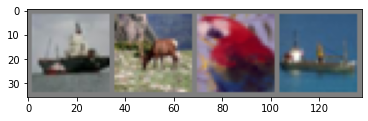

ship  deer  bird  ship 


In [4]:
import matplotlib.pyplot as plt 
import numpy as np 
# function to show an image 

def imshow(img): 
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images 
dataiter = iter(trainloder)
images, labels = dataiter.next()
#show images 

imshow(torchvision.utils.make_grid(images))
# print label 

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


<h2> Define a Convolutuion Neural network </h2>

In [22]:
import torch.nn as nn 
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 =  nn.Conv2d(6, 16, 5)
        self.fct1  = nn.Linear(16 * 5 *5, 120)
        self.fct2  = nn.Linear(120, 84)
        self.fct3  = nn.Linear(84, 10)
        
    def forward(self, x): 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions exepet batch
        x = F.relu(self.fct1(x))
        x = F.relu(self.fct2(x))
        x = self.fct3(x)
        return x
    
net = Net()



<h2> Define a loss funcation and optimzer <h1><br>


In [23]:
import torch.optim as optimzer 
#  We will use a classification Cross-Entropy loss and SGD momentum
criterion = nn.CrossEntropyLoss()
optimizer = optimzer.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [24]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloder, 0):
        print('Strat training ...')
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.224
[1,  4000] loss: 1.899
[1,  6000] loss: 1.687
[1,  8000] loss: 1.585
[1, 10000] loss: 1.507
[1, 12000] loss: 1.482
[2,  2000] loss: 1.411
[2,  4000] loss: 1.390
[2,  6000] loss: 1.391
[2,  8000] loss: 1.349
[2, 10000] loss: 1.313
[2, 12000] loss: 1.311
Finished Training


In [26]:
# save the model 
PATH = 'C:\\Users\\ysouk\\OneDrive\\Bureau\\Pythorch_Tuto\\Models\\cifar_net.pth'
torch.save(net.state_dict(), PATH)

<h2>Test the network on the test datast </h2>

We have trained the network for 2 pass over the training dataset. But we need to check if the network <br>
has learnt anything at all. <br>
<br>
We will check this by predicting the class label that the neural netowk outputs, and cheking it against<br>
the ground-truth. If the prediction is correct, we add the sample of the list of correct prediction.<br>

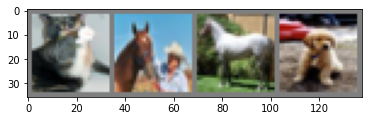

GroundTruth:  cat   horse horse dog  


In [27]:
dataiter = iter(testloader)

images, labels = dataiter.next()
#print images 
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [28]:
#  let’s load back in our saved model

net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [29]:
outputs = net(images)

In [31]:
_, predicted = torch.max(outputs, 1)

print('Predicted ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

Predicted  cat   truck car   horse


Now, we Will test the model on the whol dataset and show the results 

In [32]:
correct = 0
total = 0

with torch.no_grad():
    
    for data in testloader:
        images, labels = data
        # calculate the ouptut by runing images through the network 
        
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


In [34]:
# prepapre the count predictions for each class 
correct_pred = { classename : 0 for classename in classes}
total_pred   = { classename : 0 for classename in classes}

In [36]:
with torch.no_grad():
    
    for data in testloader: 
        
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # Collect the correct predctions for each class 
        
        for label, prediction in zip(labels, predictions): 
            if label == prediction:
                correct_pred[classes[label]] +=1
            total_pred[classes[label]] +=1
            
# print acc for each classe 

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
#

Accuracy for class: plane is 60.1 %
Accuracy for class: car   is 70.3 %
Accuracy for class: bird  is 22.0 %
Accuracy for class: cat   is 22.2 %
Accuracy for class: deer  is 47.0 %
Accuracy for class: dog   is 52.2 %
Accuracy for class: frog  is 79.5 %
Accuracy for class: horse is 54.6 %
Accuracy for class: ship  is 74.3 %
Accuracy for class: truck is 57.6 %
